In [1]:
# Imports
import numpy as np
from pydrake.all import *
from IPython.display import display, SVG, clear_output, HTML

# from manipulation.meshcat_cpp_utils import(
#     StartMeshcat, MeshcatJointSlidersThatPublish)
# from manipulation.scenarios import AddMultibodyTriad

# Import pygmo for optimisation
import pygmo as pg
from TwoLink_urdf_creator_struct import *
import time
from joblib import Parallel, delayed
from utils import *
# Import for structures
import json
from operator import itemgetter
import torch

In [4]:
meshcat = StartMeshcat()

Meshcat is now available at http://localhost:7002


In [5]:
# Load the classifiers
clf = joblib.load('./feasibility_classifier.pkl')
# Load mean and scale data
fit_file = open('./mean_and_scale.json')
fit_params = json.load(fit_file)
fit_file.close()

In [1]:
# Define the number of actuators
na = 2

# GLOBAL PROBLEM SETUP

# Reference: https://wiki.ros.org/pr2_controller_manager/safety_limits
# Defining the actuator box
class ActuatorBox(LeafSystem):
    # Input values are for motor and NOT for the joint
    def __init__(self, tau_max_m, omega_max_m, gear_ratio, k_velocity):
        LeafSystem.__init__(self)
        # Both the values are motor specific and NOT joint specific
        # Get joint max torque
        self.tau_max_j = tau_max_m*gear_ratio
        self.k_vel = k_velocity
        # Convert RPM of motor to joint velocity in rad/sec
        self.omega_max_j = omega_max_m*(2*np.pi/60)/gear_ratio
        self.DeclareVectorInputPort('commanded_torque', BasicVector(na))
        self.DeclareVectorInputPort('joint_state', BasicVector(2*na))
        self.DeclareVectorOutputPort('realised_torque', BasicVector(na), self.OutputJointTorque)

    def OutputJointTorque(self, context, output):
        # Get the state values
        q = self.EvalVectorInput(context, 1).get_value()
        qvel = q[na:]
        u = self.EvalVectorInput(context, 0).get_value()
        # Compute the instantaneous torque limit
        # For the AK-70-10 motors
        kv = self.k_vel
        u_new = np.copy(u)
        # Using URDF safety controller rules
        for i in range(len(u)):
            if qvel[i]>=0 and u[i]>=0:
                u_bound = -kv*(qvel[i]-self.omega_max_j)
                u_new[i] = np.min([u[i], u_bound, self.tau_max_j])
            if qvel[i]>=0 and u[i]<=0:
                u_bound = -self.tau_max_j
                u_new[i] = np.max([u[i], u_bound])
            if qvel[i]<=0 and u[i]>=0:
                u_bound = self.tau_max_j
                u_new[i] = np.min([u[i], u_bound])
            if qvel[i]<=0 and u[i]<=0:
                u_bound = -(-kv*(np.abs(qvel[i])-self.omega_max_j))
                u_new[i] = np.max([u[i], u_bound, -self.tau_max_j])
#             print(u[i], u_bound, u_new[i])
        output.SetFromVector(u_new)

# Task definition
# Home position
carti = np.array([-0.1, 0.14, 0.85])
qi = np.array([0.96, 0.44])
q0 = qi
cartd = np.array([-0.1, 0.32, 1.29])
qd = np.array([-0.53, 0.58])
qint = qd

# Simulation settings
time_step = 1e-4
sim_time = 5
error_threshold = 5e-3

# Robot URDF
urdf_path = './urdfs/TwoLinkRobot.urdf'
print(urdf_path)

# motor mass
m_m = 0.452
# Assumed values
tau_mu = 5.3e-3
b0 = 1.5e-5
# AK70-10 parameters
# gear ratio
gear_ratio = 10
# motor design variables
tau_max_m = 12/gear_ratio # Nm
omega_max_m = 475*gear_ratio   # RPM
Kt = 0.095        # Nm/A
Kv = 100          # RPM/V
Km = 0.19         # Nm/sqrt(W)
# Computed matrix for joule loss
K_joule = 1/np.sqrt(Km)*np.identity(na)
k_velocity = 8.33/(75*2*np.pi/60) # Nm/(rad/s)
# Control attributes
Kp = 15
Kd = 2*np.sqrt(Kp)
max_penal = 1e4

study = ["baseline_control", "baseline_motor", "baseline_codesign", "baseline_codesign_heuristics", "baseline"]

case = study[2]
if case=="baseline_control":
    # For baseline-control study
    pre_val_vals = [tau_mu, b0, Km, k_velocity, tau_max_m, omega_max_m, gear_ratio, m_m]
    pre_val_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "m_m"]
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["Kp", "Kd"]
    print(case)
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [15, 2*np.sqrt(15)]
    print(sample_dv)
    dv_bounds = ([0,0],[100,100])
    print('dv_bounds: ', dv_bounds)
    
if case=="baseline_motor":
    # For baseline-control-motor study
    pre_val_vals = []
    pre_val_names = []
    print(case)
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "Kp", "Kd", "m_m"]
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [0.0053, 1.5e-05, 0.19, 1.0606085407643906, 1.2, 4750, 10, 15, 2*np.sqrt(15), 0.452]
    print('Sample-DV: ', sample_dv)
    # Since we want to change the motor mass in the simulation here, we must include joint mass variation in the URDF
    # ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m']
    dv_bounds = ([0,0,0,1e-2,1e-3,1000,0.1, 0, 0, 0],[1,1,5,1e2,5,9000,25,100,100,5])
    print('dv_bounds: ', dv_bounds)
    
if case=="baseline_codesign":
    # For baseline-codesign study
    pre_val_vals = []
    pre_val_names = []
    print(case)
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "Kp", "Kd", "m_m", "l1", "l2", "k1", "k2","k3"]
    task_info = {'carti': carti, 'cartd': cartd}
    pre_val.update(task_info)
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [0.0053, 1.5e-05, 0.19, 1.0606085407643906, 1.2, 4750, 10, 15, 2*np.sqrt(15), 0.452, 0.36, 0.36, 646.2338,69400000,56100000]
    print('Sample-DV: ', sample_dv)
    # Since we want to change the motor mass in the simulation here, we must include joint mass variation in the URDF
    # ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m']
    dv_bounds = ([0,0,1e-4,1e-2,1e-3,1000,0.1, 0, 0, 1e-3,1e-2,1e-2, 1e3,1e3,1e3],[1,1,5,1e2,5,9000,25,100,100,5,1,1, 30900, 379000000, 379000000])
    print('dv_bounds: ', dv_bounds)

    # Limited heuristics available from the paper
if case=="baseline_codesign_heuristics":
    # For baseline-codesign study
    pre_val_names = ["tau_mu", "b0", "k_velocity"]
    pre_val_vals = [0.0053, 1.5e-05, 1.0606085407643906]
    print(case)
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = ["omega_max_m", "gear_ratio", "Kp", "Kd", "m_m", "l1", "l2"]
    print('pre_val: ', pre_val, 'dv_names: ', dv_names)
    sample_dv = [4750, 10, 15, 2*np.sqrt(15), 0.452, 0.36, 0.36]
    print('Sample-DV: ', sample_dv)
    # Since we want to change the motor mass in the simulation here, we must include joint mass variation in the URDF
    # ['tau_mu', 'b0', 'Km', 'k_velocity', 'tau_max_m', 'omega_max_m', 'gear_ratio', 'Kp', 'Kd', 'm_m']
    dv_bounds = ([1000,0.1, 0, 0, 1e-3,1e-2,1e-2],[9000,25,100,100,5,1,1])
    print('dv_bounds: ', dv_bounds)  
    
if case=="baseline":
    print(case)
    # For simulation study
    pre_val_vals = [tau_mu, b0, Km, k_velocity, tau_max_m, omega_max_m, gear_ratio, Kp, Kd, m_m]
    pre_val_names = ["tau_mu", "b0", "Km", "k_velocity", "tau_max_m", "omega_max_m", "gear_ratio", "Kp", "Kd", "m_m"]
    # Define a dictionary for ease of usage and modulartiy of the dvs
    pre_val = dict(zip(pre_val_names, pre_val_vals))
    dv_names = []
    sample_dv = []
    print(pre_val)

NameError: name 'LeafSystem' is not defined

In [7]:
def compute_QoI(pre_val, dv_names, sample_dv, case, clf, fit_params, run_sim=False):
    # Construct the master dv list
    dv_dict = dict(zip(dv_names, sample_dv))
    if case==study[3]:
        # Map the entire design space from the sampled DVs using heuristics
        # Current heuristics used are from the jump paper
        dv_dict['tau_max_m'] = 5.48*dv_dict['m_m']**0.97
        dv_dict['Km'] = 0.15*dv_dict['m_m']**1.39
        # Later also fit k_velocity values
    dv = {**pre_val, **dv_dict}
    # Construct a new URDF if its such a case
#     print(case)
    if (case==study[1]) or (case==study[2]) or (case==study[3]):
        urdf_path=urdf_creator(dv, fit_params)
    else:
        urdf_path = './urdfs/TwoLinkRobot.urdf'
    # Construct the sim diagram
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
    X_R = RigidTransform(RotationMatrix.MakeYRotation(0), np.array([-0.1, 0.5, 1]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
    if run_sim:
#         print(urdf_path)
        meshcat.Delete()
        meshcat.DeleteAddedControls()
        # Spawn table
        table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')

    # Due to the way the problem is formulated, spheres and the table can be safely ignored
    plant.Finalize()
    actuator = builder.AddSystem(ActuatorBox(dv['tau_max_m'], dv['omega_max_m'], dv['gear_ratio'], dv['k_velocity']))
    
    if run_sim:
        visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    
    # Initialise controller params, for now limited to Kp and Kd search
    Kp = np.full(na, dv['Kp'])
    Ki = np.full(na, 0)
    Kd = np.full(na, dv['Kd'])
    
    iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
    iiwa_controller.set_name("iiwa_controller");
    # Complete connections
    builder.Connect(plant.get_state_output_port(model),
                iiwa_controller.get_input_port_estimated_state())
    builder.Connect(iiwa_controller.get_output_port_control(), 
                actuator.get_input_port(0))
    builder.Connect(plant.get_state_output_port(model),
                actuator.get_input_port(1))
    builder.Connect(actuator.get_output_port(), plant.get_actuation_input_port())
    
    # Connecting a data logger
    # Commanded torque
    logger1 = LogVectorOutput(iiwa_controller.get_output_port_control(), builder)
    # Joint state
    logger2 = LogVectorOutput(plant.get_state_output_port(model), builder)
    # Realised torque
    logger3 = LogVectorOutput(actuator.get_output_port(), builder)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    gripper_frame = plant.GetBodyByName("eef").body_frame()
    
    # Now computing the QoIs
    # FEASIBILITY check
    link_lengths = np.array(itemgetter('l1', 'l2')(dv))
    input_list = np.c_[np.array([itemgetter('k1', 'k2', 'k3')(dv),]*2), link_lengths*1000]
    input_list_torch = torch.from_numpy(input_list)
    feas_mean = np.array(fit_params['feas_data']['mean'])
    feas_scale = np.array(fit_params['feas_data']['scale'])
    norm_input_list = (input_list_torch-feas_mean)/feas_scale
    pred_feas = clf.predict(norm_input_list.cpu().numpy())
    if pred_feas.all():
        feasibility = 0
    else:
        feasibility = max_penal
#     print(feasibility)
    
    # DEFLECTION
    lx = input_list[:,-1]
    ncomp = len(input_list)
    Kc = np.empty([input_list.shape[1],input_list.shape[1],input_list.shape[0]])
    for n in range(ncomp):
        K_cs1_1 = input_list[n][0]
        K_cs2_2 = input_list[n][1]
        K_cs4_4 = input_list[n][2]

        Kc[:,:,n] = np.array([[K_cs1_1,(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),-K_cs1_1,(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n])],
        [(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),K_cs2_2, -(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),   (K_cs1_1*lx[n]**2)/2 - K_cs2_2/2 - K_cs4_4/2],
        [-K_cs1_1, -(K_cs1_1*lx[n]**2 + K_cs2_2 - K_cs4_4)/(2*lx[n]),K_cs1_1, -(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n])],
        [(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n]),(K_cs1_1*lx[n]**2)/2 - K_cs2_2/2 - K_cs4_4/2, -(K_cs1_1*lx[n]**2 - K_cs2_2 + K_cs4_4)/(2*lx[n]),K_cs4_4]])
        
    # Initialising global variables
    Kg = np.zeros([(ncomp+1)*2,(ncomp+1)*2])
    Dg = np.zeros([(ncomp+1)*2,1])
    Fg = np.zeros([(ncomp+1)*2,1])
    # Constructing the global stiffness matrix
    for elx in range(ncomp):
        n1 = 2*elx
        n2 = 2*(elx+1)
        Kg[n1:n2+2, n1:n2+2] += Kc[:,:,elx]
    # Computing the displacements given the loading
    Fg[ncomp*2] = 10
    Dg = np.linalg.inv(Kg[2:,2:])@Fg[2:]
    deflection = np.max(np.abs(Dg))
#     print(deflection)
    
    # WORKSPACE
    # Workspace is always satisfied since its the same robot
    # Compute IK - pos1
    ik = InverseKinematics(plant, plant_context)
    ik.AddPositionConstraint(
                gripper_frame, [0, 0, 0], plant.world_frame(),
                dv['carti'], dv['carti'])
    prog = ik.get_mutable_prog()
    q = ik.q()
    prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
    prog.SetInitialGuess(q, q0)
    result = Solve(ik.prog())
    w1 = result.get_optimal_cost()
    qi = result.GetSolution(ik.q())
    qi = (np.arctan2(np.sin(qi), np.cos(qi)))
    
    # Compute IK - pos2
    ik = InverseKinematics(plant, plant_context)
    ik.AddPositionConstraint(
                gripper_frame, [0, 0, 0], plant.world_frame(),
                dv['cartd'], dv['cartd'])
    prog = ik.get_mutable_prog()
    q = ik.q()
    prog.AddQuadraticErrorCost(np.identity(len(q)), qi, q)
    prog.SetInitialGuess(q, qi)
    result = Solve(ik.prog())
    w2 = result.get_optimal_cost()
    qd = result.GetSolution(ik.q())
    qd = (np.arctan2(np.sin(qd), np.cos(qd)))
    workspace = w1+w2
    # APPLIED FORCE
    # Applied force will also remain the same given that the tau_max is fixed
    applied_force = 0
    # PAYLOAD
    # same as applied force
    payload = 0
    # Setup the simulation
    xd = np.hstack((qd, 0*qd))
    plant.SetPositions(plant_context, qi)
    iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), xd);
    # Simulation
    simulator = Simulator(diagram, context)
    simulator.AdvanceTo(sim_time);
    
    # Now we want to get the simulation data, i.e., 
    # the torque applied, final time of the joint variables
    log1 = logger1.FindLog(context)
    log2 = logger2.FindLog(context)
    log3 = logger3.FindLog(context)
    
    error = np.abs(log2.data()[:na,:].transpose() - np.tile(qd,(log3.data().shape[1],1)))
    e_norm = np.array([np.linalg.norm(val) for val in error])
    for i in range(len(e_norm)):
        if np.all(e_norm[i:]<error_threshold):
            break
    final_error = e_norm[-1]
    # CYCLE TIME
    ts = log2.sample_times()[i]
    
    omega_j = []
    for i in range(log2.data().shape[1]):
        omega_j.append(log2.data()[:,i][na:])
    omega_j = np.array(omega_j).transpose()
    omega_m = omega_j*dv['gear_ratio']
    # Convert the motor speed to RPM
    omega_m_rpm = omega_m*60/(2*np.pi)
    # Motor torque realised
    tau_m = log3.data()/dv['gear_ratio']
    
    K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
    # Total power losses
    inst_friction_power = []
    inst_joule_power = []
    for i in range(len(log3.sample_times())):
        omega_inst = omega_m[:, i]
        tau_f = dv['tau_mu']*np.sign(omega_inst)+dv['b0']*omega_inst
        P_f = np.dot(tau_f, omega_inst)
        inst_friction_power.append(P_f)
        tau_t = tau_f+tau_m[:, i]
        P_t = np.dot(K_joule.dot(tau_t), tau_t)
        inst_joule_power.append(P_t)
    
    # POWER LOSSES
    total_friction_loss = np.sum(inst_friction_power)*time_step
    total_joule_loss = np.sum(inst_joule_power)*time_step
    
    results = np.array([workspace, deflection, applied_force, payload, ts, total_friction_loss, total_joule_loss, final_error])
#     print(results)
    
    if run_sim:
        # Angular angular velocity of the motors in RPM
        motor_rpm = omega_j*gear_ratio*60/(2*np.pi)
        plt.plot(log2.sample_times(), motor_rpm[0, :], log2.sample_times(), motor_rpm[1, :])
        plt.title('motor RPM vs time')

        # Motor torque demanded
        fig = plt.figure()
        plt.plot(log1.sample_times(), log1.data()[0, :], log1.sample_times(), log1.data()[1, :])
        plt.title("motor torque demanded vs time")

        # Motor torque demanded
        fig = plt.figure()
        plt.plot(log1.sample_times(), log3.data()[0, :], log1.sample_times(), log3.data()[1, :])
        plt.title("motor torque realised vs time")

        print('Max realised torque', np.max(np.abs(log3.data())))

    return results

In [8]:
# test with a sample or for sim
# print(sample_dv)
# compute_QoI(pre_val, dv_names, sample_dv, case, clf, fit_params, run_sim=True)

In [36]:
# Setting up a problem
class Baseline_Problem:
    def __init__(self, pre_val, dv_names, dv_bounds, case, clf, fit_params):
        self.pre_val = pre_val
        self.dv_names = dv_names
        self.dv_bounds = dv_bounds
        self.case = case
        self.clf = clf
        self.fit_params = fit_params
        pass

    def dim(self):
        if self.case==study[0]:
            return 2
        else:
            return 0
        pass
    
    def fitness(self,sample_dv):
#         print(sample_dv)
        # Write a function to output the QoI values
        results = compute_QoI(self.pre_val, self.dv_names, sample_dv, self.case, self.clf, self.fit_params)
        # Add weighting factor, K_w
        # workspace, deflection, applied_force, payload, ts, total_friction_loss, total_joule_loss, final_error
        K_w = np.diag([1,1e2,1,1,100,5,5,1e3])
        # Quadratic objective meta function with weights
        fitness_val = np.matmul(K_w, results).dot(results)
        return [fitness_val]

    def get_bounds(self):
        # Define bounds on the controller variables
        # Ideally from a csv file like before so that one can easily extend the optimisation problem
        return self.dv_bounds

    def get_name(self):
        # get the name of the problem also from the csv sheet
        return "Baseline_Control"

    def batch_fitness(self, dvs):
        # print(dvs)
#         First, reshape the values into an array
        new_dvs = np.reshape(dvs, (12, 5)).T
        var_list = new_dvs.tolist()
        # print(var_list)
#         Now use the joblib style to evaluate the fitness
        with tqdm_joblib(tqdm(total=len(var_list))) as progress_bar:
            results = Parallel(n_jobs=-1,backend='multiprocessing')(delayed(self.fitness)(var_list[i]) for i in range(len(var_list)))
        results = list(itertools.chain(*results))
        # print(results)
        return results

#         Define custom batch fitness evaluation using joblib for efficient parallelisation
        pass

    def has_batch_fitness(self):
#         Info if the batch fitness is available
        return True

In [37]:
# Using CMA-ES
prob = pg.problem(Baseline_Problem(pre_val, dv_names, dv_bounds, case, clf, fit_params))
algo = pg.algorithm(pg.cmaes(gen = 10, sigma0=0.3, force_bounds=True))
algo.set_verbosity(100)

# Writing a custom island to see if we can make it work
# The default mp_island fails because of the pickle error from PyCapsule
# caused by drake AddMultibodyPlantSceneGraph function
class cool_isl:
    def run_evolve(self, algo, pop):
        # Island serially runs to evolve the pop
        new_pop = algo.evolve(pop)
        return algo, new_pop
    def get_name(self):
        return "This is a cool island that works"  

In [ ]:
%%time
# Atleast we have a bfe to spawn the initial pop
# Since the evolve method is the core for optimisation there 
# is nothing I can do to parallelise that part
# archi = pg.archipelago(n=1, algo = algo, prob=prob, pop_size=30, b = pg.default_bfe(), udi = cool_isl())
archi = pg.archipelago(n=1, algo = algo, prob=prob, pop_size=20, udi = cool_isl())
archi.evolve();
archi.wait_check()

CMAES 4 PaGMO: 
mu: 10 - lambda: 20 - mueff: 5.9388 - N: 15
cc: 0.222108 - cs: 0.306059 - c1: 0.00736299 - cmu: 0.0278511 - sigma: 0.3 - damps: 1.30606 - chiN: 3.80925


/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: invalid value encountered in multiply
  K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: invalid value encountered in multiply
  K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: invalid value encountered in multiply
  K_joule = 1/np.sqrt(dv['Km'])*np.identity(na)
/tmp/ipykernel_62864/1212672071.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  K_joule = 1/np.sqrt(dv['

In [ ]:
a = archi.get_champions_f()
a2 = sorted(archi.get_champions_f(), key = lambda x: x[0])[0]
best_isl_idx = [(el == a2).all() for el in a].index(True)
x_best = archi.get_champions_x()[best_isl_idx]
f_best = archi.get_champions_f()[best_isl_idx]
print(dv_names)
print("Best relaxed solution, x: {}".format(x_best))
print("Best relaxed solution, f: {}".format(f_best))

Max realised torque 49.95472582715487
[3.06387348e+00 3.50608075e-03 0.00000000e+00 0.00000000e+00
 5.00000000e+00 1.07405761e+01 3.90516168e+00 6.45652954e-03]
3162.4509225693005


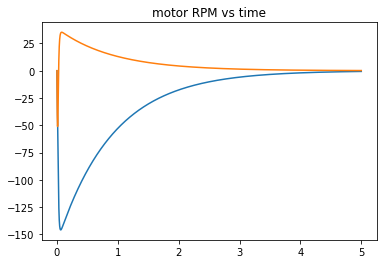

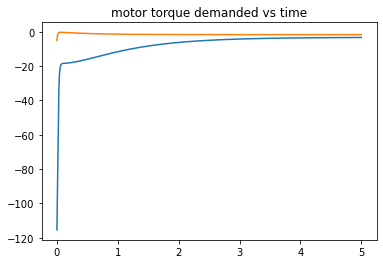

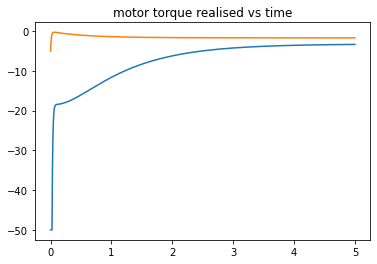

In [9]:
# Baseline data
# opt_sample = [15, 2*np.sqrt(15)]

# Control optimisation
# opt_sample = [40.37586389, 10.79584889]
# opt_sample = [23, 21]
# opt_sample = [40.70093065, 11.82625924]

# Motor optimisation
# opt_sample = [1.23963359e-01, 8.21454920e-03, 4.42151610e+00, 2.42814979e+01, 4.85943104e+00, 5.10276159e+03, 6.10012926e+00, 8.68464895e+01, 1.71650947e+01, 1.02976934e+00]

# Codesign optimisation
opt_sample = [5.05202468e-01, 0.00000000e+00, 5.00000000e+00, 2.05394500e+01,
 4.33182830e+00, 1.00000000e+03, 1.15320189e+01, 9.63436259e+01,
 8.89265165e+01, 4.46666737e+00, 3.26825103e-01, 1.58159671e-01,
 1.06972986e+04, 2.05037186e+08, 1.00000000e+03]

# Codesign with heuristics
# opt_sample = [1.75671160e+03, 2.42603688e+01, 9.78082909e+01, 1.38293459e+01,1.29247957e+00, 7.29913449e-02, 9.46402732e-02]

results = compute_QoI(pre_val, dv_names, opt_sample, case, clf, fit_params, run_sim = True)
print(results)
K_w = np.diag([1,1e3,1,1,100,5,5,0])
# Quadratic objective meta function with weights
fitness_val = np.matmul(K_w, results).dot(results)
print(fitness_val)

In [ ]:
def gripper_forward_kinematics_example():
    urdf_path = './urdfs/TwoLinkRobot.urdf'
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
    # Transform for the robot location
    X_R = RigidTransform(RotationMatrix.MakeYRotation(0), np.array([-0.1, 0.5, 1.0]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
    # Spawn table|
    table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')
    # Spawn spherical work piece
    sphere = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere')
    X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), np.array([0, 0, 0.736]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere)[0]).body_frame(), X_R)

    plant.Finalize()
    
    end_frame = "eef"
    
    # Draw the frames
    for body_name in ["base_link", end_frame]:
        AddMultibodyTriad(plant.GetFrameByName(body_name, model), scene_graph)

    meshcat.Delete()
    meshcat.DeleteAddedControls()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

#     plant.SetPositions(plant.GetMyContextFromRoot(context),
#                   plant.GetModelInstanceByName("diva_robot"),
#                   q0)
    
    gripper = plant.GetBodyByName(end_frame)
    def pose_callback(context):
        pose = plant.EvalBodyPoseInWorld(context, gripper)   ## This is the important line
        print(pose.translation())
        clear_output(wait=True)
        print("gripper position (m): " + np.array2string(
            pose.translation(), formatter={
                'float': lambda x: "{:3.2f}".format(x)}))
        print("gripper roll-pitch-yaw (rad):" + np.array2string(
            RollPitchYaw(pose.rotation()).vector(),
                         formatter={'float': lambda x: "{:3.2f}".format(x)}))
        print("pose rotation: ", pose.rotation())
    sliders = MeshcatJointSlidersThatPublish(meshcat, plant, visualizer, context)
    # sliders.Run()
    sliders.Run(pose_callback)

gripper_forward_kinematics_example()

In [ ]:
# carti = np.array([-0.1, 0.14, 0.85])
# orii = np.array([2.97, 0, 0])
# qi = np.array([0.96, 0.44])

# cartf = np.array([-0.1, 0.32, 1.29])
# orii = np.array([1.62, 0, 0])
# qi = np.array([-0.53, 0.58])